In [20]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from sunpy.time import TimeRange
import matplotlib.dates as mdates
import datetime as dt

import dask
import dask.array as da

%matplotlib notebook

In [21]:
import dask.dataframe as dd

In [22]:
fname = 'udpoutput/cygA-1s-stokesI-notimedec_0_2020-10-13T17:47:00_ld'
sbs = np.arange(76, 197)
obs_mode = 3
trange = TimeRange("2020-10-13T17:47:00", 1.*u.second)
"""
fname = 'udpoutput/jupiter-stokesI_0_2020-10-13T17:47:00_19563125244140'
sbs = np.arange(76, 319)
obs_mode = 3
trange = TimeRange("2020-10-13T17:47:00", 10.*u.minute)
"""

xlabel = "Time"
ylabel = "Frequency (MHz)"
title = "Cyg A - Stokes I"

In [23]:
def sb_to_f(sbs, obs_mode):
    nyq_dict = {3:1, 5:2, 7:3}
    nyq_zone = nyq_dict[obs_mode]
    clock_dict = {3:200, 4:160, 5:200, 6:160, 7:200} #MHz
    clock = clock_dict[obs_mode]
    nu = (nyq_zone-1. + sbs/512.) * (clock/2.)
    return nu * u.MHz

In [24]:
def bg(data, amount=0.05):
        #tmp = data - np.mean(data, axis=0) 
        sdevs = np.mean(data, 1)
        cand = sorted(range(data.shape[0]), key=lambda y: sdevs[y])
        realcand = cand[:max(1, int(amount*len(cand)))]
        bg = np.mean(data[realcand, :], 0)
        return bg

In [25]:
#df = np.fromfile(fname, dtype=np.float32)
df = np.memmap(fname, np.float32, mode="c")

In [26]:
len(sbs)

121

In [27]:
freqs = sb_to_f(sbs, obs_mode)

In [28]:
print(min(freqs).value, max(freqs))

14.84375 38.28125 MHz


In [29]:
df = df.reshape(-1, sbs.shape[0]+1)
df = np.flip(df, axis=1)

In [30]:
df.shape

(195312, 122)

In [31]:
sdf = df[::10,:]
##remove some strong rfi

In [32]:
sdf.shape
#sdf = sdf[:,40:80]

(19532, 122)

In [33]:
#sfd = sdf/ bg(sdf)

In [34]:
x_lims = list(map(dt.datetime.fromtimestamp, [trange.start.unix, trange.end.unix]))
x_lims = mdates.date2num(x_lims)

In [1]:
plt.rcParams.update({'font.size': 20})
f, ax = plt.subplots(figsize=(9,7))
ax.imshow(sdf.T, aspect='auto', origin='lower',
           vmin=np.percentile(sdf.T, 40), 
           vmax=np.percentile(sdf.T, 80),
#           extent=[x_lims[0], x_lims[1], sb_to_f(116, 3).value, sb_to_f(156, 3).value])
           extent=[x_lims[0], x_lims[1], min(freqs).value, max(freqs).value])
ax.xaxis_date()
#xlabels = ax.get_xmajorticklabels()
#ax.set_xticklabels(xlabels, rotation=30)
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
ax.set_title(title)

NameError: name 'plt' is not defined

In [36]:
#plt.savefig('jupiter_storm_zoom_.png')

In [37]:
import pyfftw
import time

In [38]:
subbands = [5,50]
a = sdf[:,[5,50]]
print("{} {}".format(sb_to_f(subbands[0]+sbs[0], obs_mode), sb_to_f(subbands[1]+sbs[0], obs_mode)))

15.8203125 MHz 24.609375 MHz


In [39]:
a = a.T

In [44]:
"""
chunk_number = 100
filter_chunk = int(a.shape[1]/chunk_number)
fft_arr = np.zeros((a.shape[0], chunk_number, filter_chunk))
for j in range(a.shape[0]):
    for i in range(chunk_number):
        print(j, i, filter_chunk)
        fft_arr[j, i, :] = pyfftw.interfaces.numpy_fft.fft(a[j, i*filter_chunk:(i+1)*filter_chunk])
"""
##it was unneccesary to do chunks for this sized data, but keep for future larger sets.

'\nchunk_number = 100\nfilter_chunk = int(a.shape[1]/chunk_number)\nfft_arr = np.zeros((a.shape[0], chunk_number, filter_chunk))\nfor j in range(a.shape[0]):\n    for i in range(chunk_number):\n        print(j, i, filter_chunk)\n        fft_arr[j, i, :] = pyfftw.interfaces.numpy_fft.fft(a[j, i*filter_chunk:(i+1)*filter_chunk])\n'

In [45]:
fft_arr.shape

(2, 100, 195)

<IPython.core.display.Javascript object>


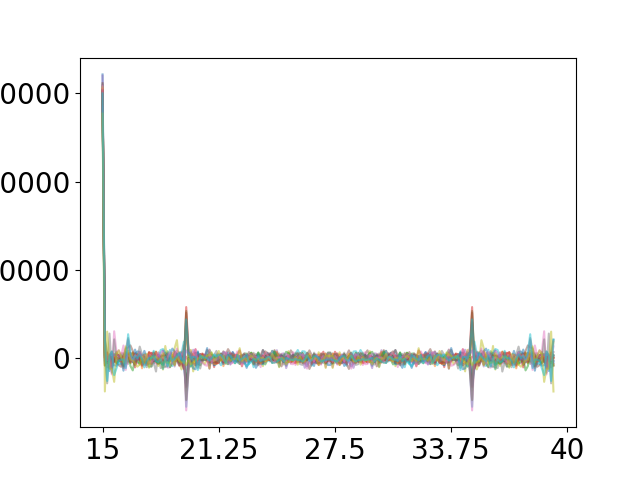

<ipython-input-46-5236a29fb3ac>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 15, 21.25, 27.5, 33.75, 40])


[Text(-50.0, 0, '0'),
 Text(0.0, 0, '15'),
 Text(50.0, 0, '21.25'),
 Text(100.0, 0, '27.5'),
 Text(150.0, 0, '33.75'),
 Text(200.0, 0, '40'),
 Text(250.0, 0, '')]

In [46]:
fig, ax = plt.subplots()
ax.plot(fft_arr[0,0:20,:].T, alpha=0.5)
ax.set_xticklabels([0, 15, 21.25, 27.5, 33.75, 40])

<IPython.core.display.Javascript object>


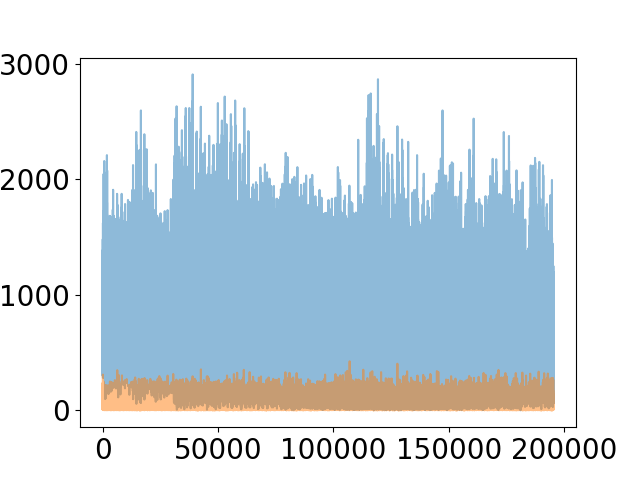

In [196]:
fig, ax = plt.subplots()
ax.plot(a, alpha=0.5)

In [213]:
start = time.time()
b = pyfftw.interfaces.numpy_fft.fft(a)
print(b.shape)
end = time.time() - start
print("Time for pyfftw: {}".format(end))

(195312, 2)
Time for pyfftw: 0.01059269905090332


<IPython.core.display.Javascript object>


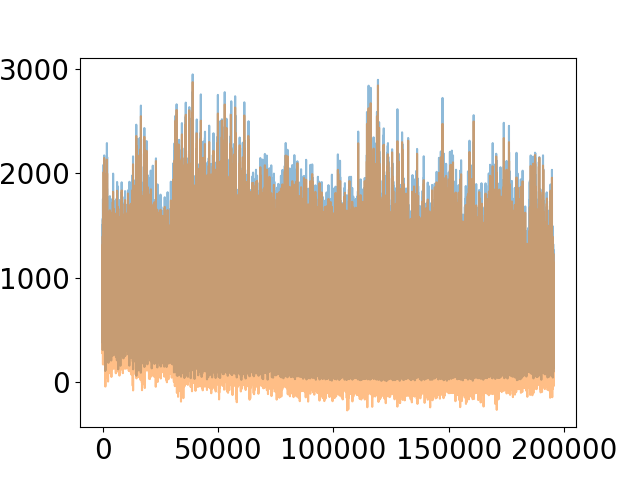

/home/ofionnad/realta/lib/python3.8/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [198]:
fig, ax = plt.subplots()
ax.plot(b, alpha=0.5)

In [199]:
start = time.time()
c = np.fft.fft(a)
end = time.time() - start
print("Time for numpy: {}".format(end))
np.allclose(b, c)

Time for numpy: 0.06883931159973145


True

<IPython.core.display.Javascript object>


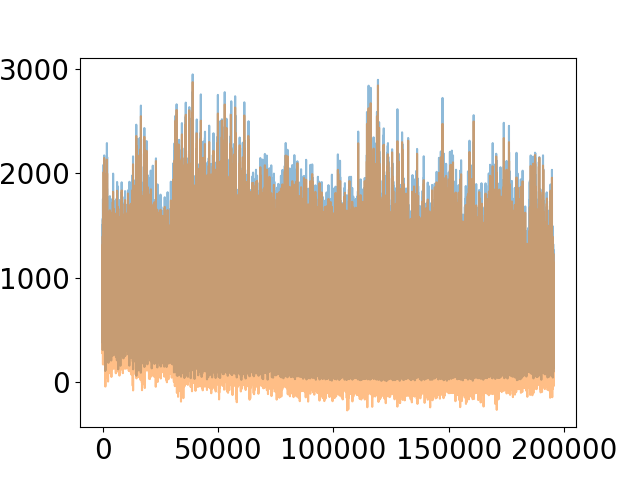

/home/ofionnad/realta/lib/python3.8/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [200]:
fig, ax = plt.subplots()
ax.plot(c, alpha=0.5)